In [1]:
from find_prices_nonoverlap import *
from sklearn import metrics
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score)
import warnings
warnings.filterwarnings(action='once')

In [2]:
df = pd.read_csv('single_family_home_values.csv')

print('Preparing Data: cleaning data')
not_useful_fields = ['id','city','state']#, 'address']
date_fields = ['lastSaleDate', 'priorSaleDate']
required_fields = ['address','latitude','longitude','zipcode','bedrooms',
                   'bathrooms','rooms','squareFootage',
                   'lotSize','yearBuilt', 'lastSaleAmount',
                   'lastSaleDate','estimated_value']
zero_to_nan_fields = None
nan_to_zero_fields = ['latitude','longitude','priorSaleDate','priorSaleAmount']

print('Preparing Data: splitting test/train/validation')
df_train, df_test, df_validation = train_validate_test_split(df)

X_test = df_test[df_test.columns.drop('estimated_value')]
y_test = df_test['estimated_value']

X_train = df_train[df_train.columns.drop('estimated_value')]
y_train = df_train['estimated_value'] 

Preparing Data: cleaning data
Preparing Data: splitting test/train/validation


In [3]:
#tzip = ImputeZipCodes()
#tzip.fit_transform(X_train,y_train)

In [4]:
from sklearn.ensemble import (
    ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor 
)
from sklearn.pipeline import FeatureUnion

print("Setting up pipeline")
features = ('latitude', 'longitude', 'zipcode',
            'bedrooms', 'bathrooms','rooms', 
            'squareFootage', 'lotSize', 
            'yearBuilt',
            'lastSaleAmount','lastSaleDateYear','lastSaleDateMonth','lastSaleDateDayOfWeek')


#: Note imputer will strip away column heads, it has to be after featurize
#reg_function = LGBMRegressor()
#reg_function = XGBRegressor()
reg_function = RandomForestRegressor(n_jobs=3)
#reg_function = GradientBoostingRegressor()
#reg_function = ExtraTreesRegressor(n_estimators=2)
#reg_function = AdaBoostRegressor(); #Really bad


# prepare_data_pipeline = Pipeline([
#             ('prepare_data', PrepareData(required_fields=required_fields,
#                                          date_fields=date_fields,
#                                         zero_to_nan_fields=zero_to_nan_fields,
#                                         nan_to_zero_fields=nan_to_zero_fields)), 
#           ('featurize', featurize(features)),
#           ('imputer', Imputer(missing_values=np.nan, strategy="mean", axis=0)),
#             ])
prepare_data_pipeline = Pipeline([
            ('prepare_data', PrepareData(required_fields=required_fields,
                                         date_fields=date_fields,
                                        zero_to_nan_fields=zero_to_nan_fields,
                                        nan_to_zero_fields=nan_to_zero_fields)), 

     ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('subject',  StreetVectorizer()),
            # Pipeline for standard bag-of-words model for body
           ('featurize', featurize(features)),
        ]
     )),
            
   
          ('imputer', Imputer(missing_values=np.nan, strategy="mean", axis=0)),
            ])
fit_data_pipeline = Pipeline([
          ('forest', reg_function)
            ])

Setting up pipeline


find_prices_nonoverlap.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.drop(labels=key, axis=1, inplace=True)
/Users/derringi/.edm/envs/may2018/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
find_prices_nonoverlap.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[field+'DayOfWeek'] = d

Warning, field priorSaleDate not in dataframe
Fitting model on training data


/Users/derringi/.edm/envs/may2018/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/derringi/.edm/envs/may2018/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Evaluating model on training data
Sqrt mse: 72839.6661294
Mean absolute error: 28451.7897889
R2 score: 0.980485065594
Absolute mean relative error: 0.0383194809825


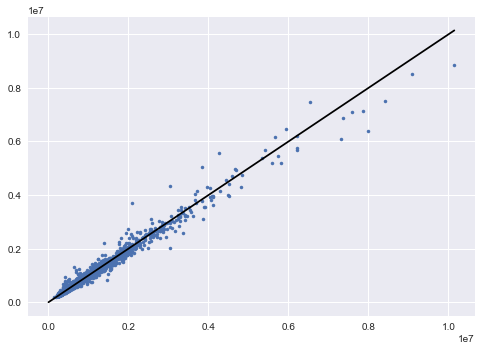

Evaluating model on testing data
Warning, field priorSaleDate not in dataframe
Sqrt mse: 149589.831345
Mean absolute error: 66444.899
R2 score: 0.891682471811
Absolute mean relative error: 0.0920464625942


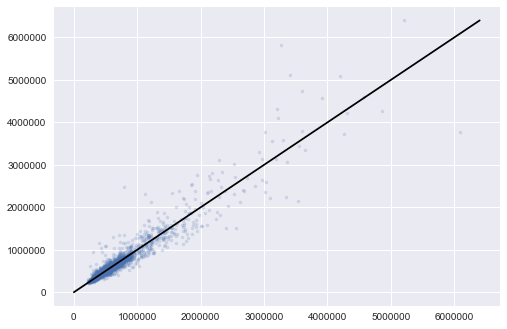

In [5]:
x_train = prepare_data_pipeline.fit_transform(X = df_train, y = y_train)

print("Fitting model on training data")
model = fit_data_pipeline.fit(X = x_train, y = y_train)

print("Evaluating model on training data")
y_pred = model.predict(x_train)
print_metrics(y_train, y_pred)
plt.plot((y_train), (y_pred),'.')
y_max = (np.max((y_train, y_pred)))
plt.plot((0,y_max), (0,y_max),color='black')
plt.show()

print("Evaluating model on testing data")
X_test = prepare_data_pipeline.transform(df_test)
y_test_pred = model.predict(X_test)
print_metrics(y_test, y_test_pred)
plt.plot((y_test), (y_test_pred),'.', alpha=0.2)
y_max = (np.max((y_test, y_test_pred)))
plt.plot((0,y_max), (0,y_max),color='black')

plt.show()

In [6]:
 ['address','latitude','longitude','zipcode','bedrooms',
                   'bathrooms','rooms','squareFootage',
                   'lotSize','yearBuilt', 'lastSaleAmount' 
                   'lastSaleDate','estimated_value']

['address',
 'latitude',
 'longitude',
 'zipcode',
 'bedrooms',
 'bathrooms',
 'rooms',
 'squareFootage',
 'lotSize',
 'yearBuilt',
 'lastSaleAmountlastSaleDate',
 'estimated_value']

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word', token_pattern='[A-Za-z]{3,}')
corpus = df_train['address']
X = vectorizer.fit_transform(corpus)

In [8]:
vectorizer.vocabulary_

{u'acoma': 0,
 u'adams': 1,
 u'alameda': 2,
 u'alamo': 3,
 u'albion': 4,
 u'allen': 5,
 u'ammons': 6,
 u'arapahoe': 7,
 u'ash': 8,
 u'ave': 9,
 u'avenue': 10,
 u'bayaud': 11,
 u'belcaro': 12,
 u'bellaire': 13,
 u'bellewood': 14,
 u'bellwood': 15,
 u'berry': 16,
 u'birch': 17,
 u'blvd': 18,
 u'bonnie': 19,
 u'brae': 20,
 u'bruce': 21,
 u'california': 22,
 u'canosa': 23,
 u'cedar': 24,
 u'center': 25,
 u'champa': 26,
 u'chenango': 27,
 u'cherokee': 28,
 u'cherry': 29,
 u'cir': 30,
 u'circle': 31,
 u'clarkson': 32,
 u'clayton': 33,
 u'clermont': 34,
 u'club': 35,
 u'colfax': 36,
 u'colorado': 37,
 u'columbine': 38,
 u'cook': 39,
 u'corona': 40,
 u'court': 41,
 u'cove': 42,
 u'creek': 43,
 u'crestline': 44,
 u'curtis': 45,
 u'dahlia': 46,
 u'dakota': 47,
 u'delaware': 48,
 u'detroit': 49,
 u'dexter': 50,
 u'division': 51,
 u'dorado': 52,
 u'downing': 53,
 u'eaton': 54,
 u'elati': 55,
 u'elizabeth': 56,
 u'ellipse': 57,
 u'elm': 58,
 u'emerson': 59,
 u'estes': 60,
 u'euclid': 61,
 u'eudora'

In [9]:
y = vectorizer.transform(df_test['address'])

In [10]:
[c,b] = np.histogram(y_pred-y, bins=np.linspace(-1e6,1e6,100))
print(np.mean(y_pred-y))
plt.plot(b[:-1],c)
plt.show()

ValueError: operands could not be broadcast together with shapes (9000,) (3000,216) 

In [ ]:

sns.distplot(np.log(df['lastSaleAmount'].values+1))
 plt.show()


In [ ]:
#: Work on using grid-searches
params = {'forest__n_estimators':  (39,42)}
# params = {'forest__n_estimators':  np.arange(3,31,3)}
from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log1p)
# transformer.transform(y)
grid = GridSearchCV(pipeline, params)
grid.fit(X = X, y = y)

#: Definining a specified cross-validation technique
cv= StratifiedKFold(n_splits=2)

# Alternatively, can say can say cv=3 to say a 3-repeat cross-validator
grid_search = GridSearchCV(pipeline, params)#, cv=cv)
#gsearch = GridSearchCV(pipeline, params)
grid_search.fit(X = X, y = y)
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

In [ ]:
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

In [ ]:
X = X_test
y=y_test
y_pred = best_pipeline.predict(X)
print(np.sqrt(metrics.mean_squared_error(y,y_pred)))
print(metrics.mean_absolute_error(y,y_pred))
print(metrics.r2_score(y,y_pred))
print(abs_mean_relative_error(y,y_pred))
plt.plot(y, y_pred,'.')
y_max = np.max((y, y_pred))
plt.plot((0,y_max), (0,y_max),color='black')
plt.show()

In [ ]:
required_fields = ['address','latitude','longitude','zipcode','bedrooms',
                   'bathrooms','rooms','squareFootage',
                   'lotSize','yearBuilt',
                   'lastSaleDate','estimated_value']
for key in iter(df.keys()):
    if key not in required_fields:
        print(key)

In [ ]:
df.drop(column=['id'])

In [ ]:
df.drop(labels='id',axis=1)

In [ ]:
df